We will test the accuracy of the algorithm with artificially generated data 


We will have a total of 5 states and a total of 8 possible clusters for the hosts to be part of.


Based on these clusters and their centroid transition matrix, a data series will be generated for each host

First set the parameters of the states

In [179]:
import numpy as np

lambdas = np.vstack([[0,0], [15,20], [37,12], [7,48], [55,75]])
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# random plot of the data
# number of points to take from each distribution centroid
size = 1000

for i, lambda_i in enumerate(lambdas):
    s1 = np.random.poisson(lambda_i[0], size)
    s2 = np.random.poisson(lambda_i[1], size)

    if i == 0:
        data = np.column_stack((s1, s2, np.array([i]*size, dtype=object)))
    else:
        data = np.append(data, np.column_stack((s1, s2, np.array([i]*size, dtype=object))), axis=0)

np.random.shuffle(data)

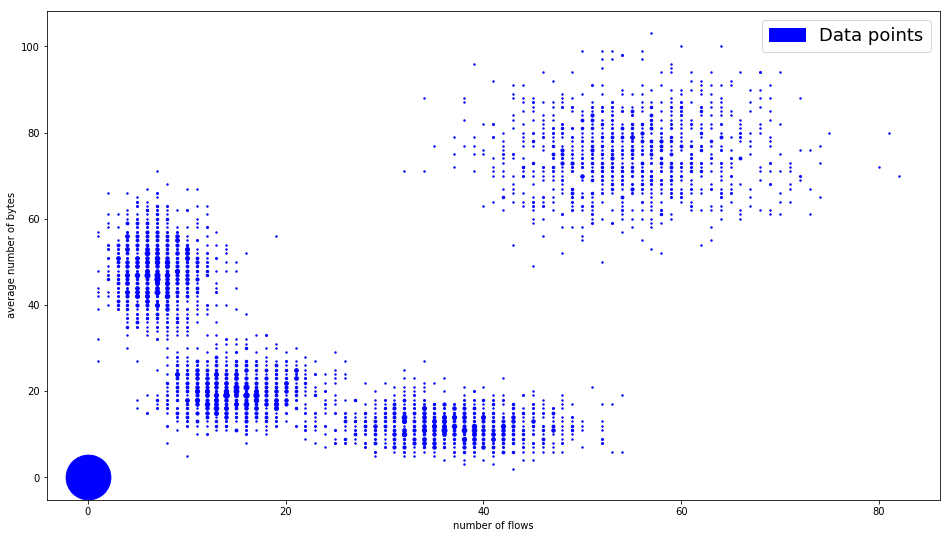

In [180]:
from plots import plot_points
%matplotlib inline

plot_points(data[:, :2])

As we can see the clusters are clearly seperated 

More precisely based only on the mass function of the distributions, the accuracy is as following

In [181]:
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

correct_classified = 0
for point in data:
    classification = np.argmax([poisson(point[:2], lambda_i) for lambda_i in lambdas])
    if classification == point[2]:
        correct_classified += 1
        
print('Accuracy of origin cluster based on mass function', correct_classified / len(data) * 100, '%')

Accuracy of origin cluster based on mass function 99.48 %


Now we will create the clusters

A total of 8 clusters will be generated each containing 25 hosts

In [182]:
import random as ran

L = 8
num_hosts_per_L = [10, 20, 30, 40, 50, 60, 70, 80]

def random_vector(size=5):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=5):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [183]:
transition_matrices = []
for i in range(L):
    transition_matrices.append(random_transition_matrix(size=len(lambdas)))

Create the points for each individual host

In [184]:
data_points = []
number_of_epochs = 500

def add_random_points(data_points, host_name, distribution, lambdas, epoch):
    axis0 = np.random.poisson(lambdas[distribution][0], 1)[0]
    axis1 = np.random.poisson(lambdas[distribution][1], 1)[0]
    data_points.append([axis0, axis1, epoch, host_name])

def random_next_state(transition_matrices, i, previous_distribution):
    r = ran.random()
    return np.where(transition_matrices[i][previous_distribution].cumsum() >= r)[0][0]
    
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        # random starting distribution
        previous_distribution = ran.randint(0, len(lambdas) - 1)
        add_random_points(data_points, host_name, previous_distribution, lambdas, 1)
        
        for k in range(2, number_of_epochs + 1):
            next_distribution = random_next_state(transition_matrices, i, previous_distribution)
            
            add_random_points(data_points, host_name, next_distribution, lambdas, k)
            
            previous_distribution = next_distribution
            

data_points = np.array(data_points,  dtype=object)

Run the EM Algorithm and the clustering

An important note is that the EM mixtures might not converge from the beginning to the desired points so on the starting epochs some of the results might not be the desired ones. This should not be a problem though.

In [185]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

In [186]:
mixtures = len(lambdas)

kplusplus = KPlusPlus(mixtures, data_points[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5


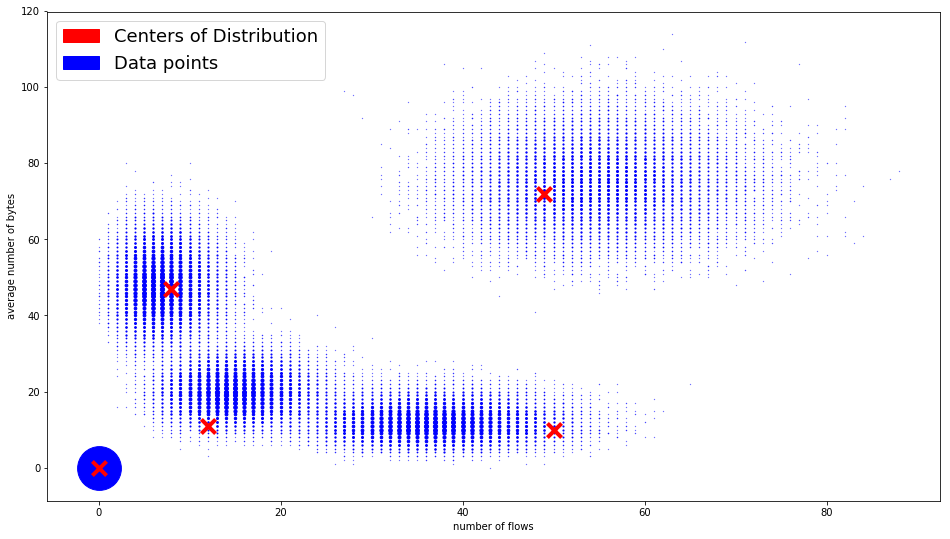

In [190]:
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, sum(num_hosts_per_L), verbose=0, update_power=0.5)

plot_points(data_points[:, :2], onlineEM)

In [191]:
onlineEM.fit(data_points[:,[0,1,3]])

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:205: RuntimeWarning: invalid value encountered in true_divide
  previous)
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


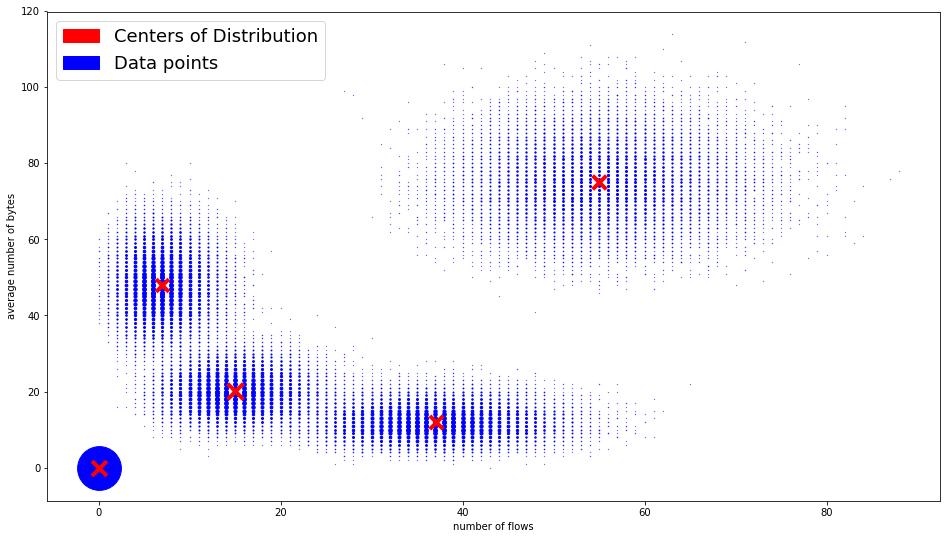

In [192]:
plot_points(data_points[:, :2], onlineEM)

In [193]:
print(onlineEM.gammas)
print(onlineEM.lambdas)

[ 0.22101442  0.16218062  0.17772483  0.18827863  0.2508015 ]
[[0.0 0.0]
 [6.9376607521195242 47.901203546350096]
 [37.040112747805175 12.086493106294011]
 [54.942471289255373 75.057546665226027]
 [14.957065156034037 20.069854069598797]]


Now we can cluster the transition matrices 

In [197]:
#from klkmeans import kMeans

kmeans = kMeans(onlineEM, n_clusters=L, initial_centers=None, n_iters=15, n_runs=5)
C, assign = kmeans.run()

Starting run
The cost is 14.3556473925
The cost is 8.3481365002
The cost is 8.24229282728
The cost is 8.23486141631
The cost is 8.197125013
The cost is 6.62437114512
The cost is 3.80924747305
converged
Starting run
The cost is 11.2250527393
The cost is 7.27882964109
The cost is 6.38797735153
The cost is 6.3872206406
converged
Starting run
The cost is 18.7163601814
The cost is 10.3766908911
The cost is 9.74284939505
converged
Starting run
The cost is 12.9543163117
The cost is 10.7966033476
The cost is 10.7911268222
The cost is 10.7890907795
The cost is 10.7883729792
The cost is 10.7875249198
The cost is 10.7870444704
converged
Starting run
The cost is 17.4064747063
The cost is 8.27923103154
The cost is 7.81180294109
The cost is 5.27005512963
The cost is 5.2379905989
The cost is 5.04890273412
The cost is 4.77740071707
converged


In [198]:
centroids = np.zeros(shape=(L, L))
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = assign[host_name]
        centroids[i][participation] += 1
    
centroids

array([[  0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.],
       [ 20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  30.,   0.,   0.,   0.,   0.],
       [  0.,  40.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  50.],
       [  0.,   0.,  60.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,  70.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  80.,   0.,   0.]])